In [26]:
import pandas as pd
import numpy as np


In [27]:
df=pd.read_csv('/content/drive/MyDrive/ML Project/Bitstamp_BTCUSD_2018_to_Today_UTC.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,2018-01-01 00:00:00+00:00,13880.00,13941.75,12801.38,13443.41,7688.030685
1,2018-01-02 00:00:00+00:00,13394.20,15257.53,12910.58,14678.94,16299.669303
2,2018-01-03 00:00:00+00:00,14670.96,15500.00,14546.28,15155.62,12275.001197
3,2018-01-04 00:00:00+00:00,15155.62,15430.27,14192.37,15143.67,15004.018593
4,2018-01-05 00:00:00+00:00,15143.67,17200.00,14810.00,16928.00,16248.914680


In [28]:
# Step 2: Convert 'Date' column to datetime (UTC-aware)
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Step 3: Remove the timezone (make it timezone-naive)
df['Date'] = df['Date'].dt.tz_localize(None)

In [29]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2018-01-01,13880.00,13941.75,12801.38,13443.41,7688.030685
1,2018-01-02,13394.20,15257.53,12910.58,14678.94,16299.669303
2,2018-01-03,14670.96,15500.00,14546.28,15155.62,12275.001197
3,2018-01-04,15155.62,15430.27,14192.37,15143.67,15004.018593
4,2018-01-05,15143.67,17200.00,14810.00,16928.00,16248.914680


In [30]:
df.sort_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2018-01-01,13880.00,13941.75,12801.38,13443.41,7688.030685
1,2018-01-02,13394.20,15257.53,12910.58,14678.94,16299.669303
2,2018-01-03,14670.96,15500.00,14546.28,15155.62,12275.001197
3,2018-01-04,15155.62,15430.27,14192.37,15143.67,15004.018593
4,2018-01-05,15143.67,17200.00,14810.00,16928.00,16248.914680


# Checking outliers using boxplo

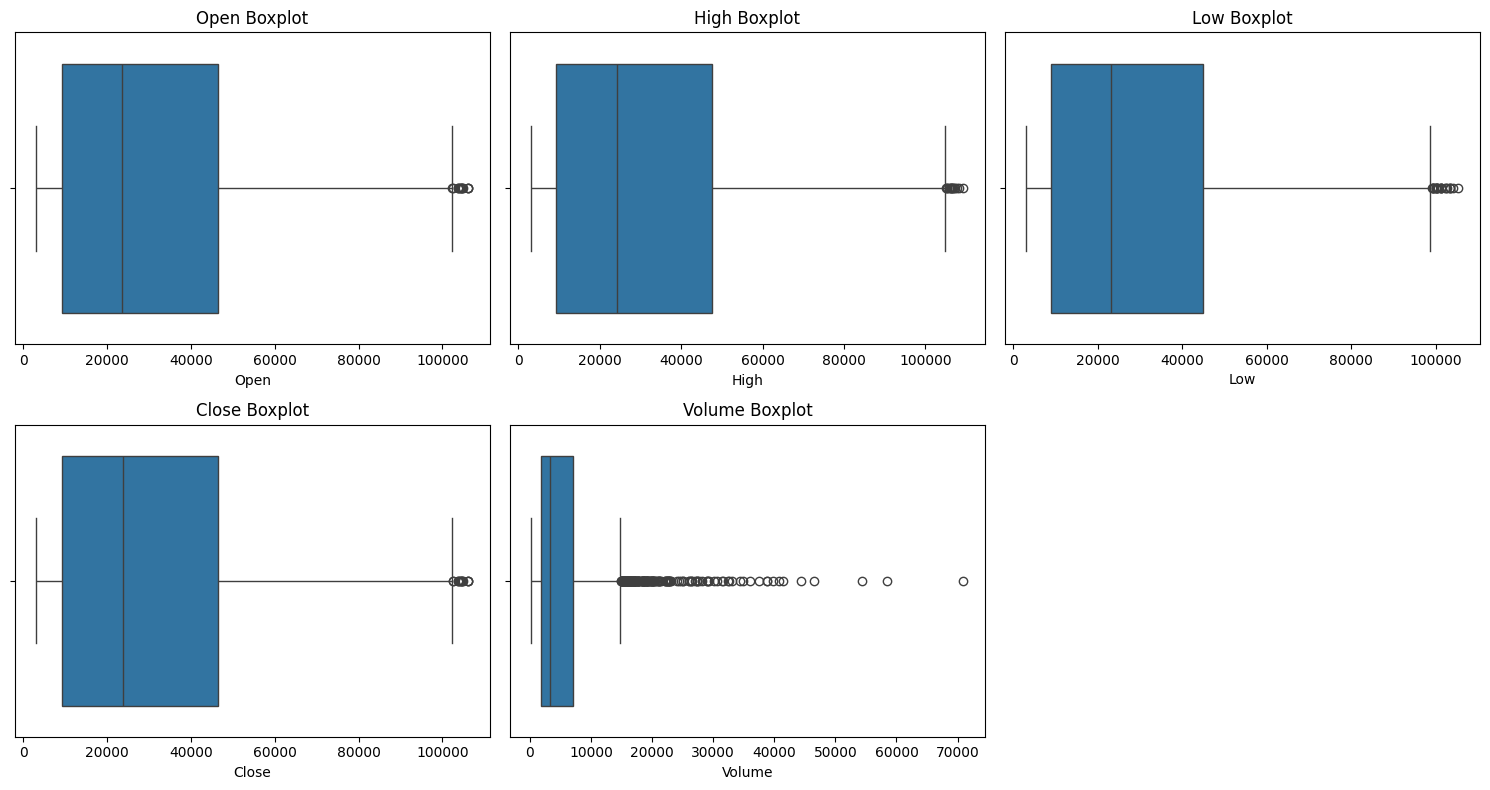

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
for i, column in enumerate(['Open', 'High', 'Low', 'Close', 'Volume'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'{column} Boxplot')
plt.tight_layout()
plt.show()

# See outliers using IQR method

In [32]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col} has {len(outliers)} outliers")

Open has 14 outliers
High has 15 outliers
Low has 23 outliers
Close has 14 outliers
Volume has 181 outliers


# Z-score

In [33]:
from scipy.stats import zscore

z_scores = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(zscore)
outliers = (z_scores.abs() > 3)  # Mark values with Z-score > 3
print(outliers.sum())  # Number of outliers per column

Open       0
High       0
Low        1
Close      0
Volume    44
dtype: int64


# Removing outliers

In [34]:
def remove_outliers_iqr(data, columns):
    df_cleaned = data.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Remove rows where the value is an outlier
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
    return df_cleaned


# results of Outliers

In [35]:
cols_to_check = ['Open', 'High', 'Low', 'Close', 'Volume']
df_cleaned = remove_outliers_iqr(df, cols_to_check)

print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")


Original shape: (2680, 6)
Cleaned shape: (2471, 6)


# Visualiztion after cleaning outliers

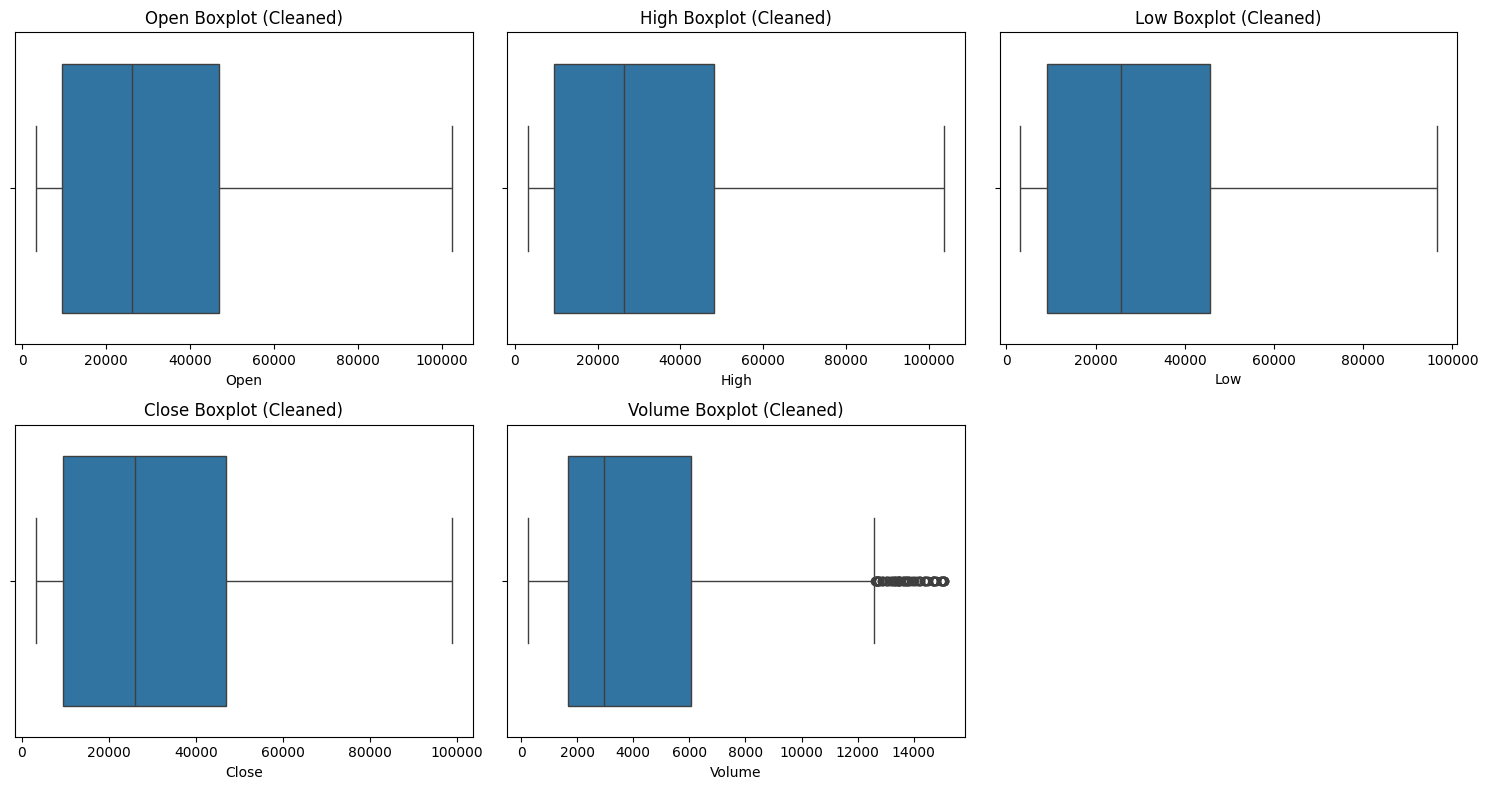

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
for i, column in enumerate(['Open', 'High', 'Low', 'Close', 'Volume'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_cleaned[column])
    plt.title(f'{column} Boxplot (Cleaned)')
plt.tight_layout()
plt.show()


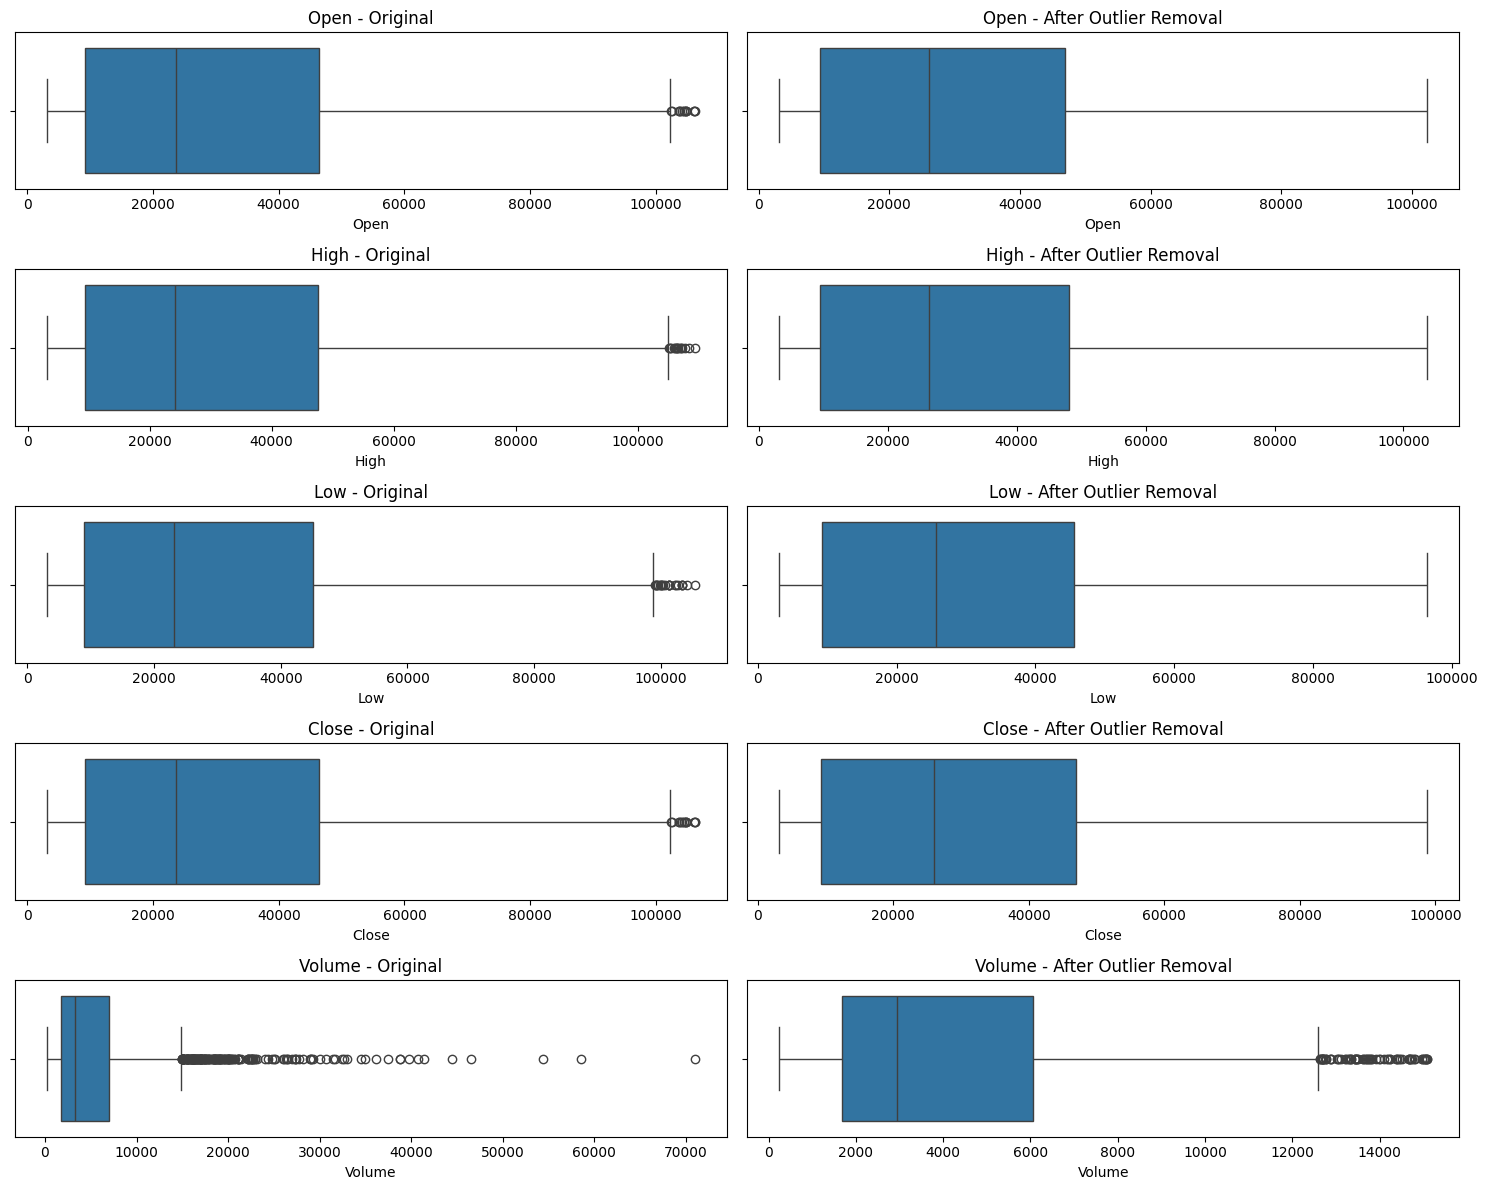

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(15, 12))
for i, column in enumerate(columns):
    # Before removing outliers
    plt.subplot(len(columns), 2, 2*i + 1)
    sns.boxplot(x=df[column])
    plt.title(f'{column} - Original')

    # After removing outliers
    plt.subplot(len(columns), 2, 2*i + 2)
    sns.boxplot(x=df_cleaned[column])
    plt.title(f'{column} - After Outlier Removal')

plt.tight_layout()
plt.show()


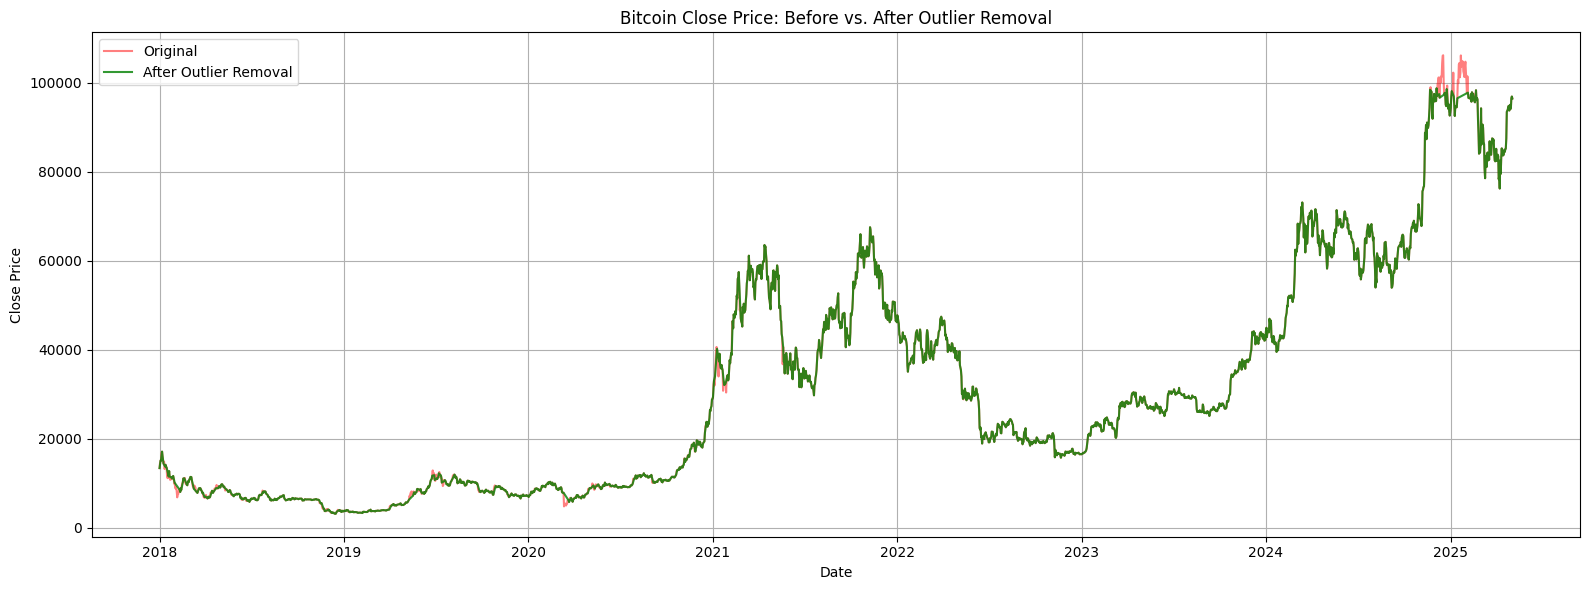

In [38]:
import matplotlib.pyplot as plt

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Sort by date just in case
df = df.sort_values('Date')
df_cleaned = df_cleaned.sort_values('Date')

plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], label='Original', alpha=0.5, color='red')
plt.plot(df_cleaned['Date'], df_cleaned['Close'], label='After Outlier Removal', alpha=0.8, color='green')
plt.title('Bitcoin Close Price: Before vs. After Outlier Removal')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Handle the Volume column for outliers

In [39]:
def remove_outliers_iqr_strict(data, column, threshold=1.0):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR
    upper = Q3 + threshold * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df_cleaned_volume = remove_outliers_iqr_strict(df_cleaned, 'Volume')


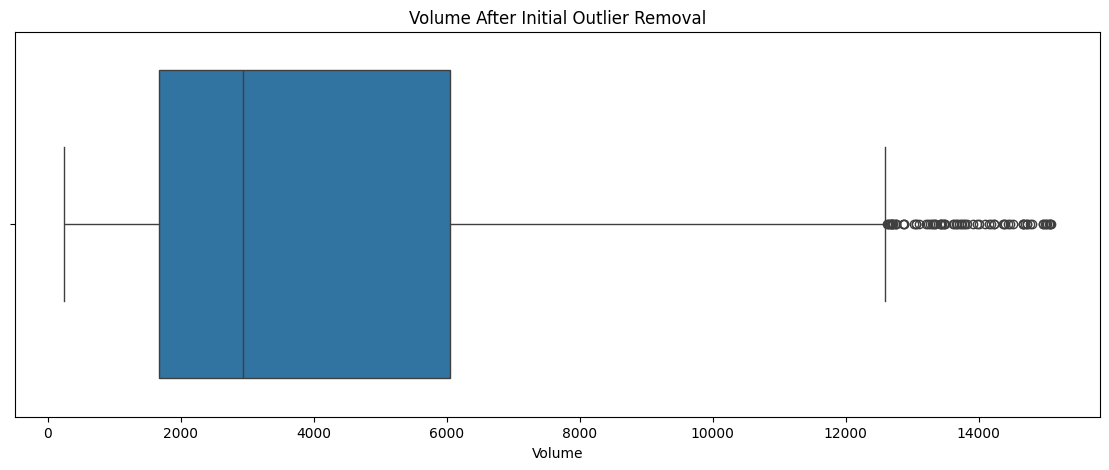

In [40]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_cleaned['Volume'])
plt.title("Volume After Initial Outlier Removal")
plt.show()


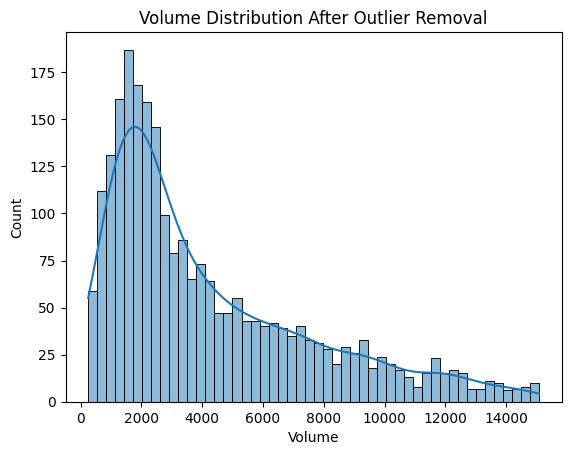

In [41]:
sns.histplot(df_cleaned['Volume'], bins=50, kde=True)
plt.title("Volume Distribution After Outlier Removal")
plt.show()


# Apply Log Transformation onto the volumn to Compress Extremes

In [42]:
import numpy as np

df_cleaned['log_volume'] = np.log1p(df_cleaned['Volume'])  # log1p is safe even if Volume = 0


# again visualize

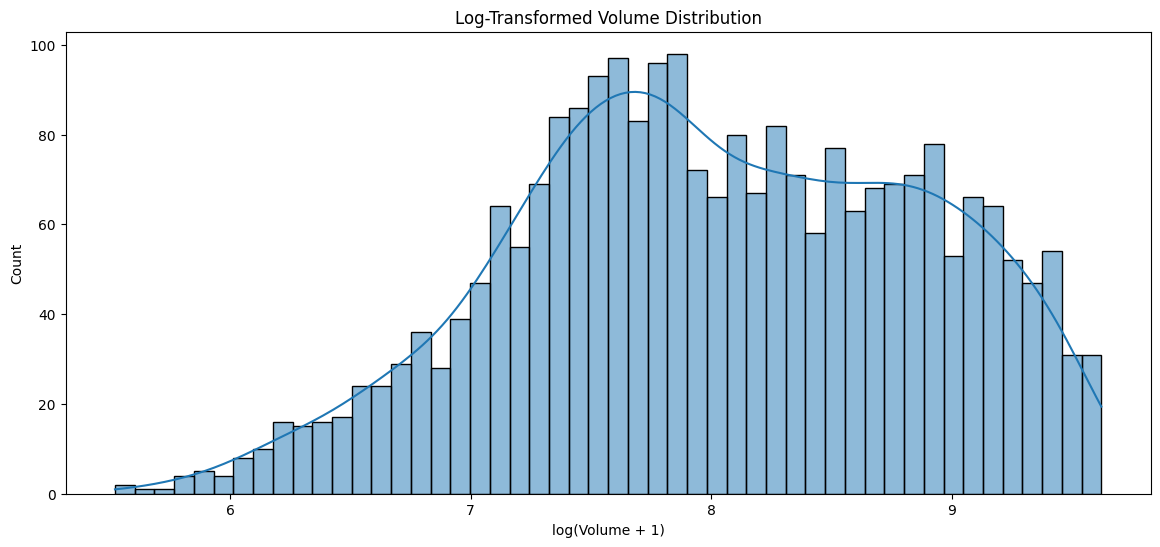

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.histplot(df_cleaned['log_volume'], bins=50, kde=True)
plt.title("Log-Transformed Volume Distribution")
plt.xlabel("log(Volume + 1)")
plt.show()

# Scale using Min-Max Scalar

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features you're using for prediction
scaled_data = scaler.fit_transform(df_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']])


# Step 1: Sequence Creation for Multivariate Time Series



In [45]:
import numpy as np

seq_length = 60  # number of past time steps to use

# Use scaled features (already scaled) and Close as target
features = scaled_data  # shape: (num_samples, 5)
target = scaled_data[:, 3]  # 'Close' is the 4th column (index 3)

def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])  # previous seq_length days
        y.append(target[i])  # current day's Close
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, seq_length)

# Train-test split (no shuffle since it's time series)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


#  Step 2: LSTM Model



In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0160 - val_loss: 0.0027
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0011 - val_loss: 0.0026


 # Step 3: GRU Model



In [47]:
from tensorflow.keras.layers import GRU

# GRU model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0241 - val_loss: 0.0011
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0014 - val_loss: 8.2333e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0013 - val_loss: 8.3910e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0011 - val_loss: 7.7053e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 9.9766e-04 - val_loss: 8.8106e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 9.4744e-04 - val_loss: 0.0011
Epoch 12/50
61/61 ━━━━━━━━━━━━

In [48]:
from sklearn.metrics import mean_squared_error
import math

# Predict
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# Only need to inverse transform the 'Close' column
# Create a scaler just for 'Close' (column index 3)
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

# Inverse transform
lstm_pred_inv = close_scaler.inverse_transform(lstm_pred)
gru_pred_inv = close_scaler.inverse_transform(gru_pred)
y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
lstm_rmse = math.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
gru_rmse = math.sqrt(mean_squared_error(y_test_inv, gru_pred_inv))

print(f"LSTM RMSE: {lstm_rmse}")
print(f"GRU RMSE: {gru_rmse}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
LSTM RMSE: 4368.626404760459
GRU RMSE: 2653.5219032815226


In [49]:
from sklearn.metrics import mean_squared_error, r2_score
import math

# Predict (on scaled data)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# RMSE (in scaled space)
lstm_rmse = math.sqrt(mean_squared_error(y_test, lstm_pred))
gru_rmse = math.sqrt(mean_squared_error(y_test, gru_pred))

# R² Score (in scaled space)
lstm_r2 = r2_score(y_test, lstm_pred)
gru_r2 = r2_score(y_test, gru_pred)

# Print
print(f"LSTM RMSE (scaled): {lstm_rmse:.4f}")
print(f"LSTM R² Score (scaled): {lstm_r2:.4f}")
print(f"GRU RMSE (scaled): {gru_rmse:.4f}")
print(f"GRU R² Score (scaled): {gru_r2:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM RMSE (scaled): 0.0457
LSTM R² Score (scaled): 0.9313
GRU RMSE (scaled): 0.0278
GRU R² Score (scaled): 0.9747


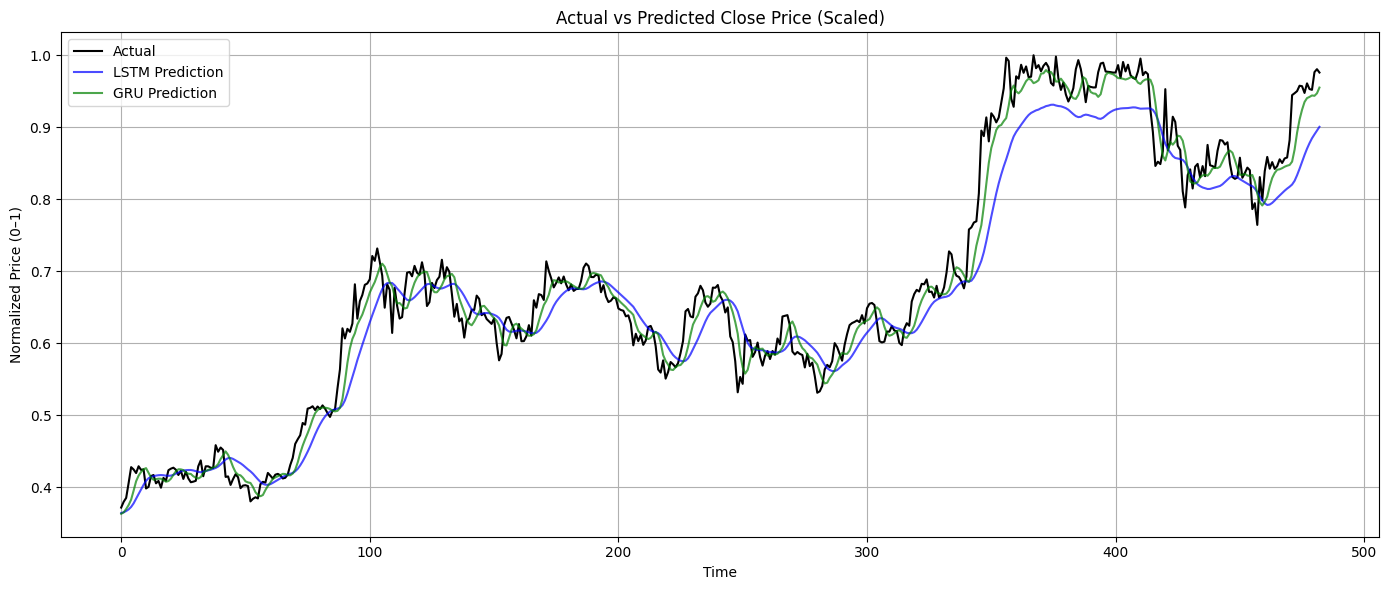

In [50]:
import matplotlib.pyplot as plt

# Plotting function
def plot_predictions(y_true, lstm_pred, gru_pred, title_suffix="(Scaled)"):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Actual', color='black')
    plt.plot(lstm_pred, label='LSTM Prediction', color='blue', alpha=0.7)
    plt.plot(gru_pred, label='GRU Prediction', color='green', alpha=0.7)
    plt.title(f"Actual vs Predicted Close Price {title_suffix}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Price (0–1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call function
plot_predictions(y_test, lstm_pred, gru_pred)


#  Inverse Transform Predictions & True Values

In [51]:
# Reuse original scaler and extract the 'Close' scaler parameters
close_min = scaler.min_[3]
close_scale = scaler.scale_[3]

# Inverse transform (manual since we only care about 'Close')
lstm_pred_inv = lstm_pred / close_scale + close_min
gru_pred_inv = gru_pred / close_scale + close_min
y_test_inv = y_test.reshape(-1, 1) / close_scale + close_min


# Plot Actual vs Predicted (Real Price)

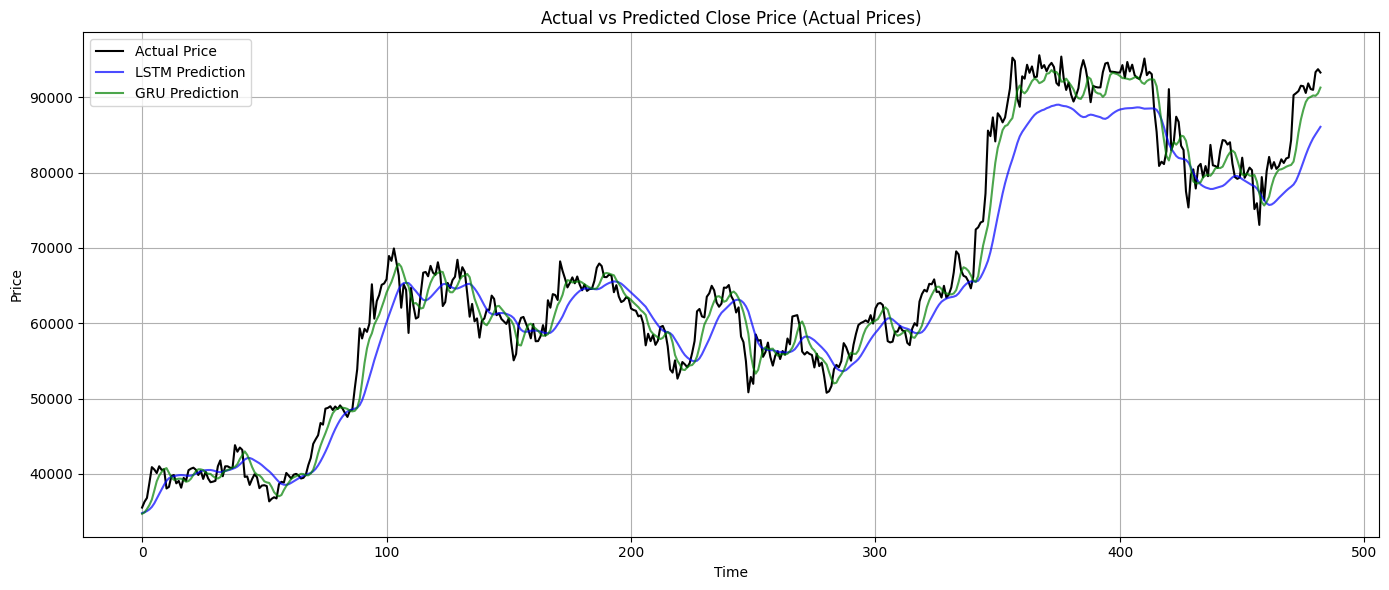

In [52]:
# Plotting function (real price version)
def plot_predictions_real(y_true, lstm_pred, gru_pred, title_suffix="(Actual Prices)"):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Actual Price', color='black')
    plt.plot(lstm_pred, label='LSTM Prediction', color='blue', alpha=0.7)
    plt.plot(gru_pred, label='GRU Prediction', color='green', alpha=0.7)
    plt.title(f"Actual vs Predicted Close Price {title_suffix}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call function
plot_predictions_real(y_test_inv, lstm_pred_inv, gru_pred_inv)


In [54]:
# Save the LSTM model
lstm_model.save('/content/lstm_model.keras')

# Save the GRU model
gru_model.save('/content/gru_model.keras')


In [55]:
from google.colab import files

# Download the models
files.download('/content/lstm_model.keras')
files.download('/content/gru_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>